INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Calculating matrix composition during heat treatment for Fe-30Ni
Matrix phase identified as ['FCC_A1'] at 900.0 K.
Matrix conditions: {X_NI: 0.2989999999999997, N: 1, P: 101325, T: 900.0}
Performing cooling calculation
Predicting evolution of ['BCC_A2' 'FCC_A1' ''] phases.
Final matrix conditions: {N: 1, P: 101325, T: 750, X_NI: 0.30515015607540874}
Calculating matrix composition during heat treatment for Fe-12Ni-15Cr
Matrix phase identified as ['FCC_A1'] at 900.0 K.
Matrix conditions: {X_NI: 0.11700000000000009, X_CR: 0.15100000000000233, N: 1, P: 101325, T: 900.0}
Performing cooling calculation
Predicting evolution of ['BCC_A2' 'FCC_A1' '' ''] phases.
Final matrix conditions: {N: 1, P: 101325, T: 750, X_CR: 0.15307252098301052, X_NI: 0.07837397751647353}
Calculating matrix composition during heat treatment for Fe-31Ni-6Co
Matrix phase identifi

Text(0, 0.5, 'Predicted Shear Modulus (Pa)')

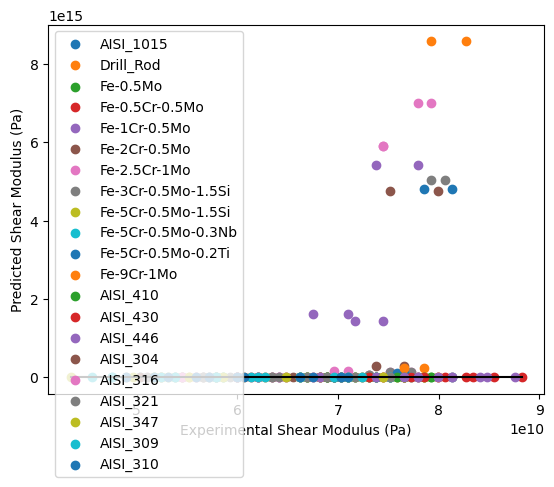

In [1]:
### Testing shear modulus property model.
from libreCalphad.models.utilities import parse_composition
from libreCalphad.models.steels import ShearModulusModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from pycalphad import Database, equilibrium, variables as v

solute_threshold = 0.005
refit = True
recalc_calphad = False
db = Database('/home/matt/opt/calphadopendb/calphadOpenDB/databases/mf-steel.tdb')
exp_data = pd.read_excel('/home/matt/mnt/flow/reference/experimental_datasets/elastic/shear_modulus.ods')

def F_to_K(temp):
    return (temp-32)/1.8 + 273.15


def calculate_matrix_composition(row, db):
    quench = False
    austenitization_disabled_phases = ['FCC_L10', 'FCC_L12', 'BCC_B2', 'BCC_D03', 'GAS', 'GRAPHITE_A9', 'DIAMOND_A4', 'HCP_L12']
    quench_disabled_phases = austenitization_disabled_phases.extend(['M23C6', 'M7C3', 'LAVES_C14', 'LAVES_C15', 'LAVES_C36', 'M6C_E93', 'SIGMA_D8B', 'MU_D85'])  # assume alloy carbides do not form on quenching
    components = row['components']
    if 'VA' not in components:
        components.append('VA')
    conditions = row['conditions']
    heat_treatment = row['heat_treatment']
    matrix_conditions = row['conditions']
    no_steps = len(heat_treatment.split('~'))
    ret_dict = {}
    for step in range(no_steps):  # some multi-step heat treatments defined
        step_treatment = heat_treatment.split('~')[step]
        if len(step_treatment.split('_')) > 1:  # heat treatment fully defined
            step_temperature = float(step_treatment.split('_')[0].split('|')[0])
            if step_treatment.split('_')[0].split('|')[1] == 'F':  # convert F to K
                step_temperature = F_to_K(step_temperature)
        elif step_treatment == 'AR':
            step_temperature = 1273  # assume 1000 C austenitization
        elif 'WQ' in step_treatment:  # assume carbides precipitate during slow cooling
            quench = True
        cooling_temperature = 750  # semi-arbitrarily chosen to calculate phase compositions when carbides present from tempering
        matrix_conditions.update({v.N: 1, v.P: 101325})

        # First try to predict the composition of the ferrite or austenite matrix at elevated temperature
        matrix_comp_phases = [phase for phase in list(db.phases.keys()) if phase not in austenitization_disabled_phases]
        print(f"Calculating matrix composition during heat treatment for {row['material']}")
        stable_phases = []
        while len(stable_phases) == 0:
            matrix_conditions.update({v.T: step_temperature})
            eq = equilibrium(db, components, matrix_comp_phases, matrix_conditions)
            stable_phases = [phase for phase in eq.Phase.squeeze().values if phase != '']
            if len(stable_phases) == 0:  # need to slightly adjust temperature because sometimes pycalphad gets "stuck"
                print("Calculation failed to predict phase stability, adding 2 K to temperature.")
                step_temperature += 2
        
        ret_dict[f'conditions-{step}'] = [matrix_conditions]

        max_eq = eq.where(eq.NP == np.max(eq.NP))
        mat_NP = max_eq.NP.squeeze()[~pd.isnull(max_eq.NP.squeeze())]
        mat_phase = max_eq.Phase.squeeze()[~pd.isnull(max_eq.Phase.squeeze())]
        assert mat_phase in ['BCC_A2', 'FCC_A1'], f"Incorrect matrix phase ({mat_phase}) identified for {row['material'][0]} at {step_temperature} K."
        assert mat_NP >= 0.5, f"Cannot identify a matrix phase for {row['material'][0]} at {step_temperature} K."
        print(f"Matrix phase identified as {mat_phase.values} at {step_temperature} K.")

        matrix_components = ['FE', 'VA']
        # Find the composition of the matrix phase and update the conditions for the next calculation accordingly
        for component in max_eq.component.values:
            x_comp = max_eq.sel(component=component).X.squeeze().values
            x_comp = x_comp[~pd.isnull(x_comp)][0]
            if component != 'FE' and component != 'VA':
                matrix_conditions.update({v.X(component): x_comp})
                matrix_components.append(component)
            if component == 'FE' and x_comp < 0.5:
                print(f"Matrix phase is Fe-poor with {conditions}")
                row['calc_error'] = True
        for condition in matrix_conditions.keys():
            if type(condition) == v.Species:
                if str(condition).split('_')[1] not in max_eq.component.values:
                    print(f"Removing {str(condition)} from matrix composition.")
                    del(matrix_conditions[condition])
                    matrix_components.pop(str(condition).split('_')[1])
        
        print(f"Matrix conditions: {matrix_conditions}")
        if step == no_steps - 1:  # final step, calculate matrix composition after cooling
            print(f"Performing cooling calculation")
            matrix_conditions.update({v.T: cooling_temperature})
            if quench:
                cooling_phases = [phase for phase in list(db.phases.keys()) if phase not in quench_disabled_phases]
            else:
                cooling_phases = matrix_comp_phases
            cooling_eq = equilibrium(db, matrix_components, cooling_phases, matrix_conditions)
            ret_dict['conditions-cooling'] = [matrix_conditions]
            print(f"Predicting evolution of {cooling_eq.Phase.squeeze().values} phases.")
            max_eq = cooling_eq.where(cooling_eq.NP == np.max(cooling_eq.NP))
            mat_NP = max_eq.NP.squeeze()[~pd.isnull(max_eq.NP.squeeze())].values
            mat_phase = max_eq.Phase.squeeze()[~pd.isnull(max_eq.Phase.squeeze())].values[0]
            ret_dict['matrix_phase-cooling'] = mat_phase
            assert mat_phase in ['BCC_A2', 'FCC_A1'], f"Incorrect matrix phase ({mat_phase}) identified for {row['material'][0]} at {cooling_temperature} K."
            if mat_NP < 0.5:
                print(f"Identified matrix phase for {row['material']} ({mat_phase}) at {cooling_temperature} K not majority phase fraction ({mat_NP}).")

            matrix_components = ['FE', 'VA']
            matrix_conditions = {v.N: 1, v.P: 101325, v.T: cooling_temperature}
            # Find the composition of the matrix phase and update the conditions for the next calculation accordingly
            for component in max_eq.component.values:
                x_comp = max_eq.sel(component=component).X.squeeze().values
                x_comp = x_comp[~pd.isnull(x_comp)][0]
                if x_comp < solute_threshold:
                    continue
                else:
                    if component != 'FE' and component != 'VA':
                        matrix_conditions.update({v.X(component): x_comp})
                        matrix_components.append(component)
                    if component == 'FE' and x_comp < 0.5:
                        print(f"Matrix phase is Fe-poor with {conditions}")
                        row['calc_error'] = True

    ret_dict['matrix_components'] = [matrix_components]
    ret_dict['matrix_phase'] = [mat_phase]
    ret_dict['matrix_conditions'] = [matrix_conditions]

    print(f"Final matrix conditions: {matrix_conditions}")
    return ret_dict


def pred_modulus(row, db, calphad_df):
    print(f"Predicting shear modulus for {row['material']}")
    matrix_components = calphad_df.query(f"material == '{row['material']}'").iloc[0]['matrix_components']
    mat_phase = calphad_df.query(f"material == '{row['material']}'").iloc[0]['matrix_phase']
    matrix_conditions = calphad_df.query(f"material == '{row['material']}'").iloc[0]['matrix_conditions']

    print(f"Matrix phase: {mat_phase}, conditions {matrix_conditions}")
    modulus_model = ShearModulusModel(db, matrix_components, mat_phase)
    models = {mat_phase: modulus_model}
    shear_modulus = 0.0
    
    while shear_modulus == 0.0:
        if row['temperature'] < 298.15:
            row['temperature'] = 298.15
        matrix_conditions.update({v.T: row['temperature']})       
        eq = equilibrium(db, matrix_components, mat_phase, matrix_conditions, model=models, output='shear_modulus')
        shear_modulus = eq.shear_modulus.squeeze().values
        if shear_modulus == 0.0:
            row['temperature'] += 5  # increase temperature until a viable shear modulus can be calculated
            print(f"Increasing temperature for {row['material']} from {row['temperature']-5} to {row['temperature']}")
    eq = equilibrium(db, matrix_components, mat_phase, matrix_conditions, model=models, output='TC')
    curie_temp = eq.TC.squeeze().values

    row['predicted_shear_modulus'] = shear_modulus
    row['curie_temperature'] = [curie_temp]
    row['matrix_conditions'] = [matrix_conditions]
    return row
    
def get_shear_modulus_model(row):
    shear_modulus = modulus_df.query(f"material == '{row['material']}' & temperature == {row['temperature']}")['predicted_shear_modulus']
    if len(shear_modulus) > 0:
        return shear_modulus.values
    else:
        return 0
    
if refit:
    pandarallel.initialize(nb_workers=12)
    exp_data = exp_data.apply(lambda row: parse_composition(row), axis=1)
    modulus_df = pd.DataFrame()
    for material in exp_data['material'].unique():
        for temperature in exp_data.query("material == @material")['temperature'].unique():
            sub_df = exp_data.query("material == @material & temperature == @temperature").iloc[0]  # only need to grab one entry
            mod_dict = {'components': [sub_df['components']],
                        'conditions': [sub_df['conditions']],
                        'phase': [sub_df['phase']],
                        'temperature': [temperature],
                        'material': [material],
                        'heat_treatment': [sub_df['heat_treatment']],
                        'calc_error': [False],}
            if len(modulus_df) == 0:
                modulus_df = pd.DataFrame(mod_dict)
            else:
                modulus_df = pd.concat([modulus_df, pd.DataFrame(mod_dict)])
    modulus_df = modulus_df.reset_index(drop=True)
    if recalc_calphad:
        calphad_df = pd.DataFrame(columns=['material', 'matrix_components', 'matrix_phase', 'matrix_conditions'])  # DataFrame for storing the results of calphad models for each material.
    else:
        calphad_df = pd.read_pickle('./shear_modulus_calphad.pkl')
    for material in exp_data['material'].unique():
        row = exp_data.query("material == @material").iloc[0]  # just grab the first entry
        prior_calc = calphad_df.query(f"material == '{row['material']}'").copy()
        if len(prior_calc) > 0 and not recalc_calphad:
            continue
        else:
            mat_dict = calculate_matrix_composition(row, db)
            mat_dict['material'] = [material]
            calphad_df = pd.concat([calphad_df, pd.DataFrame(mat_dict)])
            calphad_df.reset_index(drop=True)
            calphad_df.to_pickle('./shear_modulus_calphad.pkl')

    print("CALPHAD calculations completed, predicting shear modulus.")
    modulus_df = modulus_df.apply(lambda row: pred_modulus(row, db, calphad_df), axis=1)
    exp_data['predicted_shear_modulus'] = exp_data.apply(lambda row: get_shear_modulus_model(row), axis=1)
    exp_data['curie_temperature'] = exp_data.apply(lambda row: modulus_df.query(f"material == '{row['material']}' & temperature == {row['temperature']}")['curie_temperature'].values, axis=1)
    exp_data['error'] = exp_data.apply(lambda row: np.abs(row['shear_modulus'] - row['predicted_shear_modulus']), axis=1)
    exp_data.to_pickle('./shear_modulus_experimental.pkl')
    modulus_df.to_pickle('./shear_modulus_model.pkl')
else:
    exp_data = pd.read_pickle('./shear_modulus.pkl')
    calphad_df = pd.read_pickle('./shear_modulus_calphad.pkl')

exp_data = exp_data.query("predicted_shear_modulus != 0.0")
fig, ax = plt.subplots()
for material in exp_data['material'].unique():
    sub_df = exp_data.query("material == @material")
    ax.scatter(sub_df['shear_modulus'], sub_df['predicted_shear_modulus'], label=material)
line = np.linspace(np.min(exp_data['shear_modulus']), np.max(exp_data['shear_modulus']))
ax.plot(line, line, color='black')
ax.legend()
ax.set_xlabel('Experimental Shear Modulus (Pa)')
ax.set_ylabel('Predicted Shear Modulus (Pa)')

In [102]:
import pandas as pd
from pycalphad import Database, equilibrium, variables as v

db = Database('/home/matt/opt/calphadopendb/calphadOpenDB/databases/mf-steel.tdb')
material = 'Fe-1Cr-0.5Mo'
calphad_df = pd.read_pickle('./shear_modulus_calphad.pkl').query("material == @material")
exp_data = pd.read_pickle('./shear_modulus.pkl').query("material == @material")
modulus_df = pd.read_pickle('./shear_modulus_model.pkl').query("material == @material")

austenitization_disabled_phases = ['FCC_L10', 'FCC_L12', 'BCC_B2', 'BCC_D03', 'GAS', 'GRAPHITE_A9', 'DIAMOND_A4', 'HCP_L12']
phases = [phase for phase in list(db.phases.keys()) if phase not in austenitization_disabled_phases]
# eq = equilibrium(db, comps, phases, cond)

In [103]:
modulus_df

,components,conditions,phase,temperature,material,heat_treatment,calc_error,predicted_shear_modulus,curie_temperature,matrix_conditions
22,"[FE, C, MN, SI, CR, MO]","{X_C: 0.001, X_MN: 0.0043, X_SI: 0.0084, X_CR:...",alpha,300.000000,Fe-1Cr-0.5Mo,1650|F_0.5|hr_AC,False,5.881876492125751e+18,[1022.5859290285634],"[{N: 1, P: 101325, T: 866.483333333333, X_CR: ..."
23,"[FE, C, MN, SI, CR, MO]","{X_C: 0.001, X_MN: 0.0043, X_SI: 0.0084, X_CR:...",alpha,422.038889,Fe-1Cr-0.5Mo,1650|F_0.5|hr_AC,False,5411872802558992.0,[1025.5400587864249],"[{N: 1, P: 101325, T: 866.483333333333, X_CR: ..."
24,"[FE, C, MN, SI, CR, MO]","{X_C: 0.001, X_MN: 0.0043, X_SI: 0.0084, X_CR:...",alpha,533.150000,Fe-1Cr-0.5Mo,1650|F_0.5|hr_AC,False,1445508754900999.2,[1029.0474140944973],"[{N: 1, P: 101325, T: 866.483333333333, X_CR: ..."
25,"[FE, C, MN, SI, CR, MO]","{X_C: 0.001, X_MN: 0.0043, X_SI: 0.0084, X_CR:...",alpha,644.261111,Fe-1Cr-0.5Mo,1650|F_0.5|hr_AC,False,1602871730135255.0,[1032.1289654068503],"[{N: 1, P: 101325, T: 866.483333333333, X_CR: ..."
26,"[FE, C, MN, SI, CR, MO]","{X_C: 0.001, X_MN: 0.0043, X_SI: 0.0084, X_CR:...",alpha,755.372222,Fe-1Cr-0.5Mo,1650|F_0.5|hr_AC,False,65733324276.43968,[1032.9791640160915],"[{N: 1, P: 101325, T: 866.483333333333, X_CR: ..."
27,"[FE, C, MN, SI, CR, MO]","{X_C: 0.001, X_MN: 0.0043, X_SI: 0.0084, X_CR:...",alpha,866.483333,Fe-1Cr-0.5Mo,1650|F_0.5|hr_AC,False,60964084699.922516,[1032.9791640260532],"[{N: 1, P: 101325, T: 866.483333333333, X_CR: ..."


/tmp/ipykernel_5360/1672801436.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


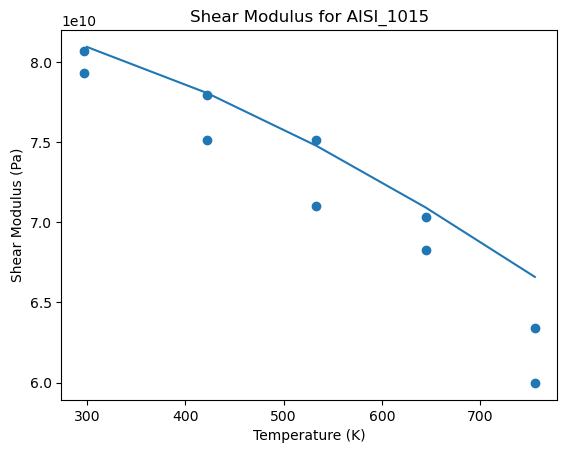

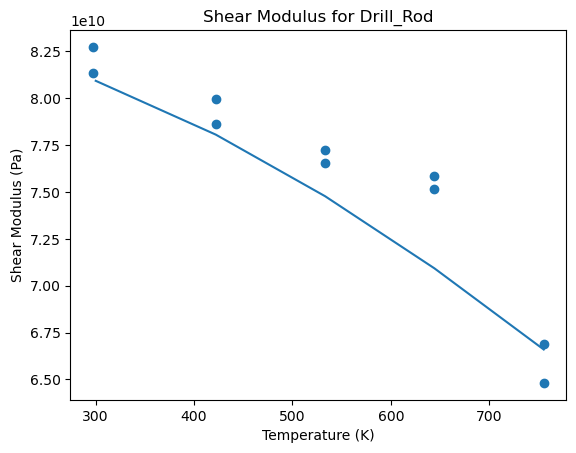

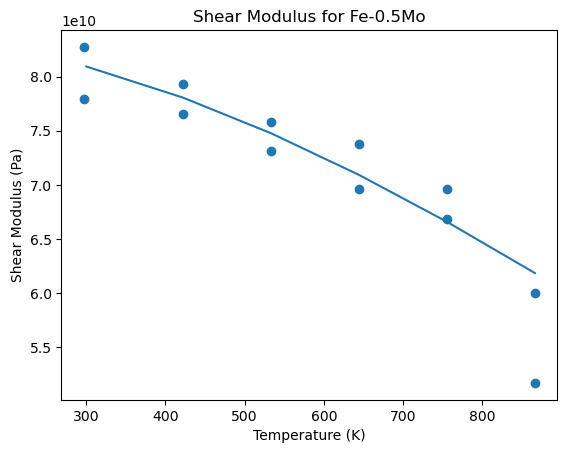

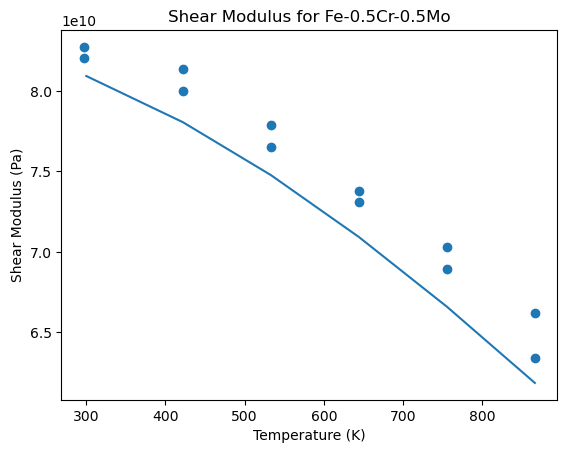

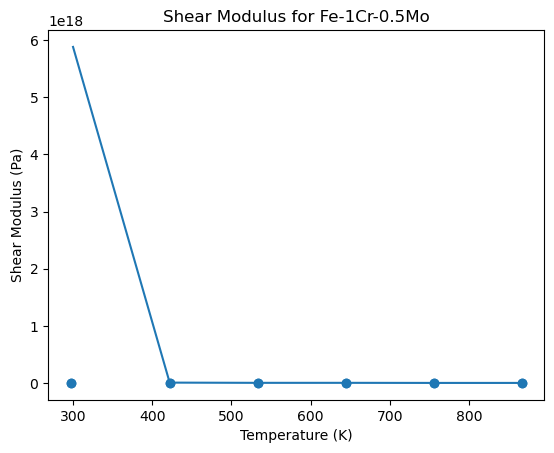

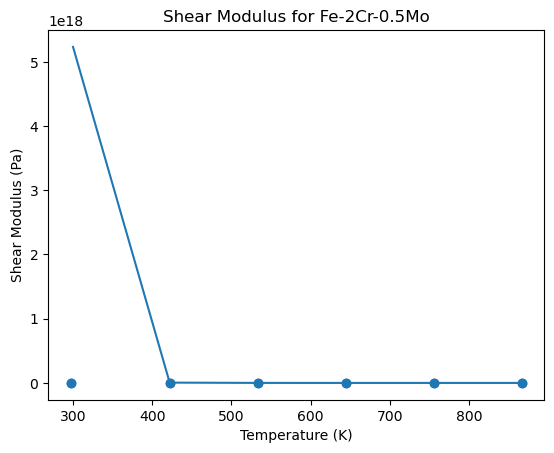

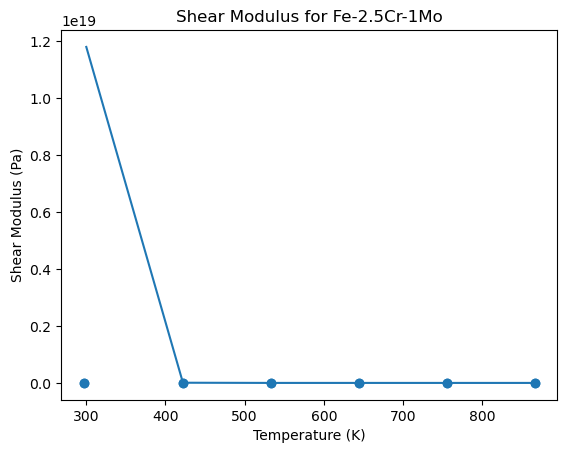

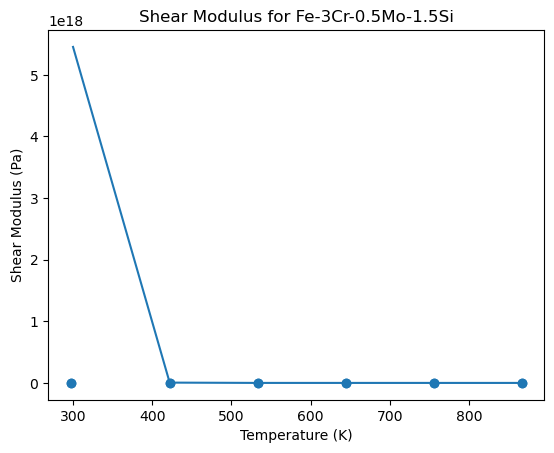

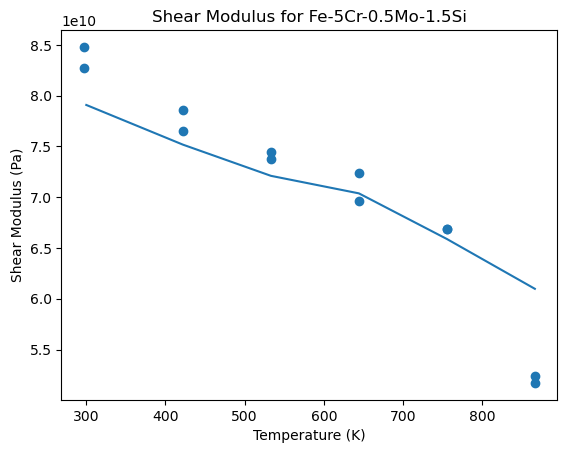

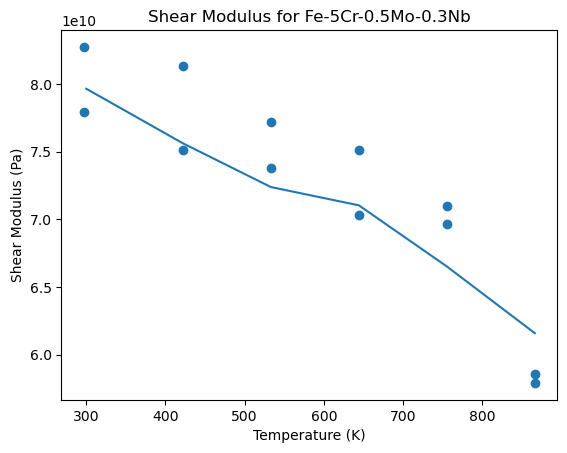

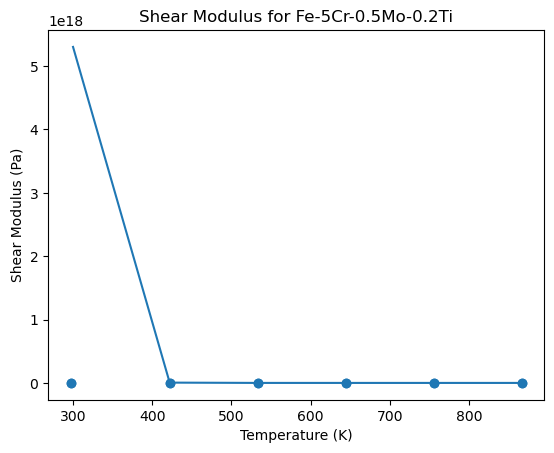

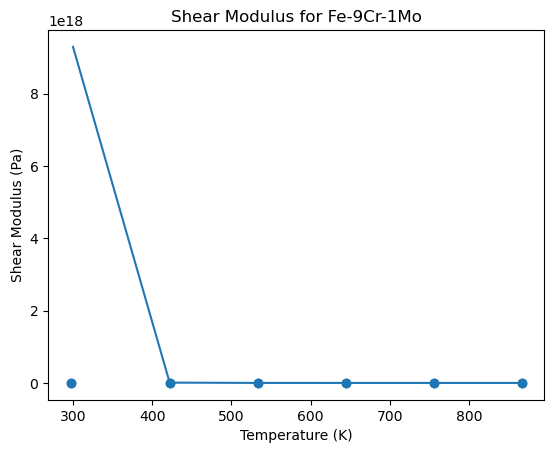

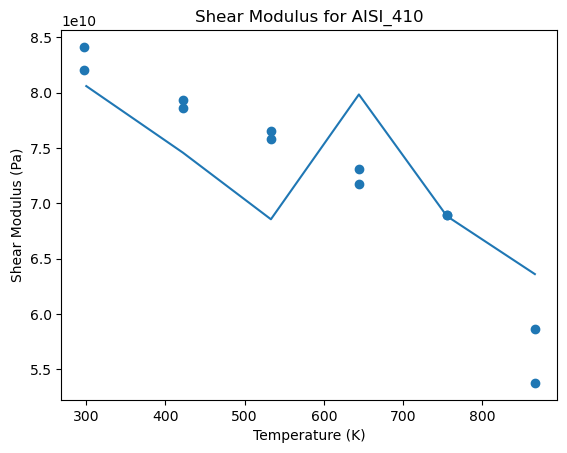

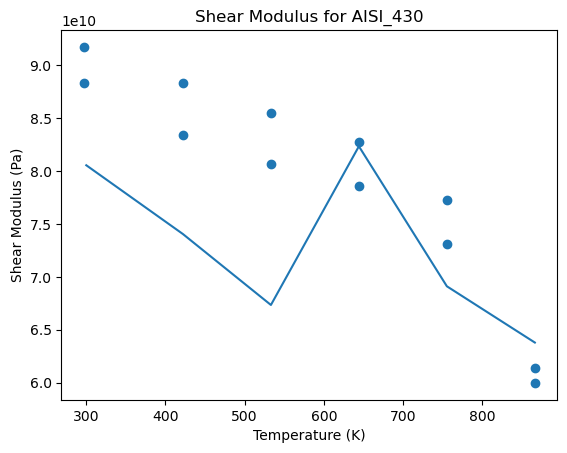

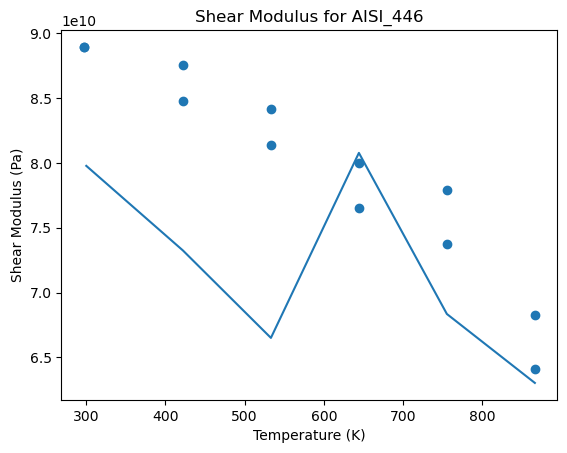

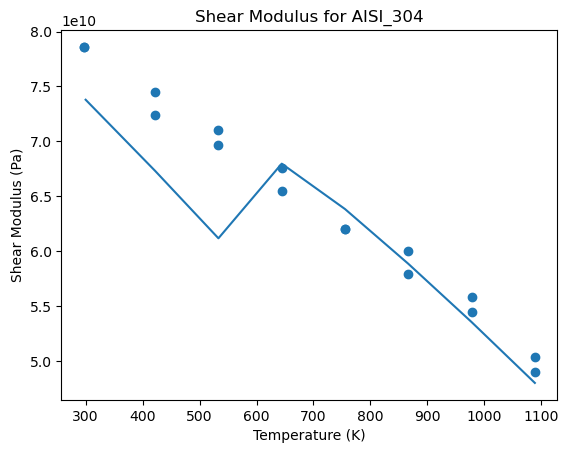

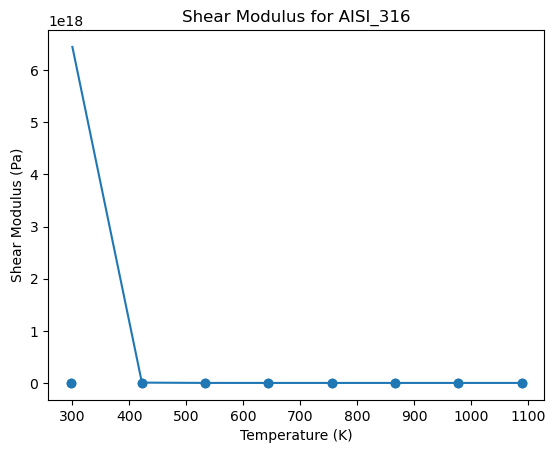

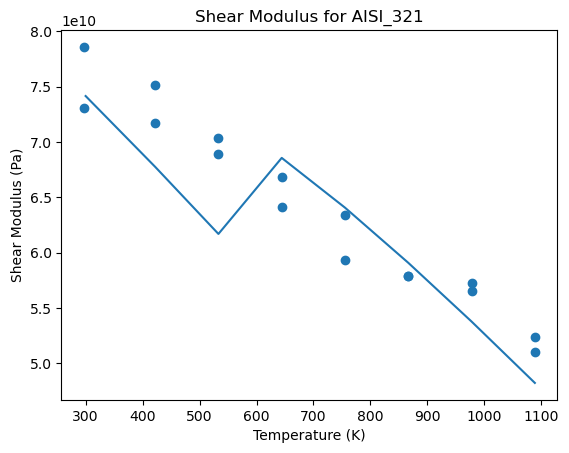

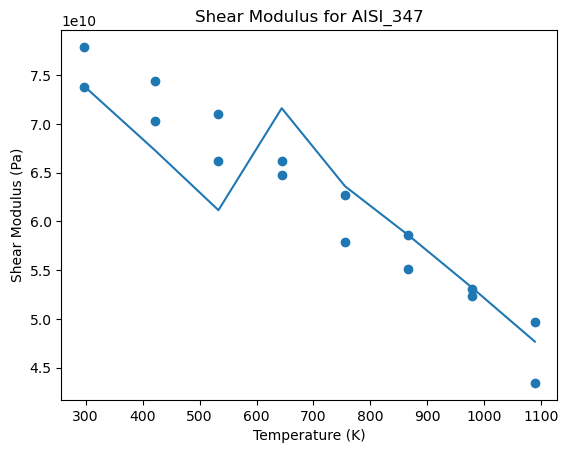

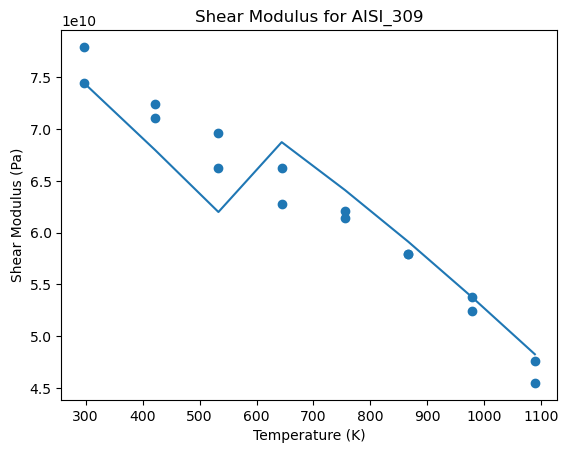

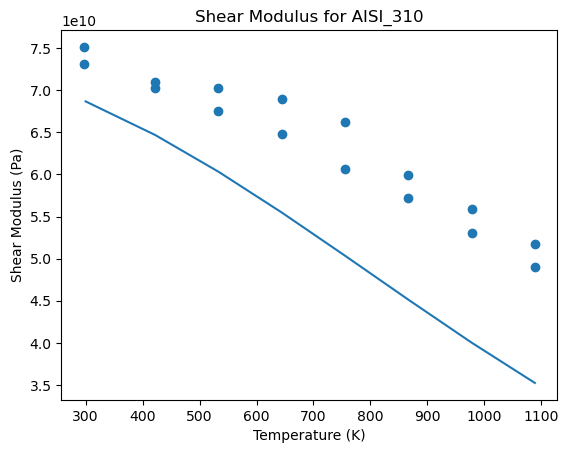

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

exp_data = pd.read_pickle('./shear_modulus.pkl')
model_data = pd.read_pickle('./shear_modulus_model.pkl')
cols_to_keep = ['material', 'temperature']

for material in exp_data['material'].unique():
    sub_exp = exp_data.query("material == @material")
    sub_mod = model_data.query("material == @material")
    # agg_df = sub_df.groupby(['temperature']).agg(np.mean)
    fig, ax = plt.subplots()
    ax.scatter(sub_exp['temperature'], sub_exp['shear_modulus'], label='experimental')
    ax.plot(sub_mod['temperature'], sub_mod['predicted_shear_modulus'], label='predicted')
    ax.set_title(f"Shear Modulus for {material}")
    ax.set_xlabel("Temperature (K)")
    ax.set_ylabel("Shear Modulus (Pa)")

In [34]:
sub_df.columns

Index(['C', 'Cr', 'Cu', 'Fe', 'Mn', 'Mo', 'Nb', 'Ni', 'P', 'S', 'Si', 'Ti',
       'alloy_system', 'comments', 'components', 'composition', 'conditions',
       'figure_no', 'heat_treatment', 'ignore', 'material', 'material_at%',
       'material_wt%', 'phase', 'reference', 'shear_modulus', 'system',
       'temperature', 'verified', 'predicted_shear_modulus', 'error'],
      dtype='object')